In [150]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import json
from glob import glob
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 处理文件

## 1.1 处理ini文件

In [10]:
# 数据处理函数
def process_screw(num, screw):
    # 定义需要提取的字段
    fields = [
        'FillDataOK', 'FinalTorque', 'FinalAngle', 'jiajinli',
        'MaxAngle', 'MinAngle', 'ScrewNum', 'PostPressForce', 'Result'
    ]
    item = {field: screw.get(field, '') for field in fields}
    
    # 处理Point数据
    point = screw.get('Point', {})
    item['Point_X'] = point.get('X', '')
    item['Point_Y'] = point.get('Y', '')
    
    # 截取前5个数据点
    torque_data = screw.get('TorqueData', {}).get('$values', [])
    # item['TorqueData'] = ', '.join(map(str, torque_data)) if torque_data else ''
    item['TorqueData'] = torque_data
    
    angle_data = screw.get('AngleData', {}).get('$values', [])
    # item['AngleData'] = ', '.join(map(str, angle_data)) if angle_data else ''
    item['AngleData'] = angle_data

    item['ScrewIndex'] = num
    
    return item

def parsefile(file):
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read().strip()

    # 去除可能的非JSON部分（如头部注释）
    cleaned_content = ("{" + content.split("{", 1)[-1].rsplit("}", 1)[0] + "}").strip()
    data = json.loads(cleaned_content)

    screw_index = {0: 4, 1: 2, 2: 1, 3: 41}
    # 提取数据
    rows = []
    for idx, group in enumerate(data['atlasData']['$values'][:4]):
        item = process_screw(screw_index.get(idx), group['$values'][0])
        item['time'] = data['WatchId']
        item['HsgSn'] = data['HsgSn']
        rows.append(item)

    # 创建DataFrame
    df = pd.DataFrame(rows)
    return df

In [11]:
files = glob("../datas/NPI-LG锁螺丝原始数据-20250716-0731/*/*.ini")
dfs = []

for file in files:
    dfs.append(parsefile(file))

df = pd.concat(dfs, ignore_index=True)
df.columns = [x.lower() for x in df.columns]
df['time'] = pd.to_datetime(df['time'].str[:12], format='%Y%m%d%H%M%S')

In [12]:
df['row_index'] = df.groupby(['hsgsn'])['hsgsn'].cumcount()
df = df.sort_values(['time', 'row_index'])[[      # , 'jiajinli' 'point_x', 'point_y'
    'hsgsn', 'time', 'screwindex', 'torquedata', 'angledata', 'result', 'filldataok', 'finaltorque', 
    'finalangle', 'maxangle', 'minangle', 'screwnum',
]]

## 1.2 join tcm datas

In [ ]:
tcm_datas = pd.read_csv("../datas/NPI数据收集/LG-1/tcmdata.csv")

In [13]:
df_use = pd.merge(df, tcm_datas, how="inner", left_on=['hsgsn', 'screwindex'], right_on=['SN', 'screw position'])

# 2. 分析

In [14]:
df_use['recommended_action'].value_counts()

recommended_action
Continue    7506
Rework        11
FA             3
Name: count, dtype: int64

## 2.1 绘图

In [6]:
print(df_use.columns.tolist())

['hsgsn', 'time', 'screwindex', 'torquedata', 'angledata', 'result', 'filldataok', 'finaltorque', 'finalangle', 'maxangle', 'minangle', 'screwnum', 'DateTime', 'Pass/Fail', 'filename', 'SN', 'screw position', 'screw number', 'failure_clamp', 'failure_slip', 'failure_rehit', 'failure_angle', 'failure_trigger_lost', 'failure_free_spin', 'failure_cross_thread', 'failure_target_torque', 'failure_excess_friction', 'failure_script', 'failure_clamptorque_spec', 'failure_clampangle_spec', 'failure_loaddata', 'target_torque_result', 'clamp_torque_result', 'clamp_angle_max_result', 'clamp_angle_min_result', 'recommended_action', 'angle_start', 'angle_max', 'torque_start', 'torque_max', 'torque_final', 'clamp_torque', 'clamp_angle', 'torque_sit', 'angle_sit', 'max_torque_before_sit', 'angle_at_maxTorque_before_sit', 'angular_work_total', 'angular_work_after_sit', 'angular_work_before_sit', 'clamp_torque_percentage', 'torque_sit_percentage', 'Normalized_integral', 'gradient_mean', 'gradient_stdev'

In [34]:
screw_order = [1, 2, 4, 41]

def validate_data(row):
    """验证每个样本的angle和torque数据长度是否一致"""
    if len(row['angledata']) != len(row['torquedata']):
        print(f"警告：样本 {row.name} 的angledata和torquedata长度不一致（{len(row['angledata'])} vs {len(row['torquedata'])}），已跳过")
        return False
    return True

def filter_negative_values(angle_list, torque_list, min_value=0):
    """
    同步过滤angle和torque中的负值数据（保留两者均≥min_value的点）
    返回过滤后的(angle_sublist, torque_sublist)
    """
    # 生成索引列表，仅保留两者均≥min_value的位置 
    valid_indices = [
        idx for idx, (a, t) in enumerate(zip(angle_list, torque_list)) 
        if a > min_value and t > min_value
    ]
    # 提取过滤后的子列表（若没有有效数据返回空列表）
    angle_sub = [angle_list[idx] for idx in valid_indices] if valid_indices else []
    torque_sub = [torque_list[idx] for idx in valid_indices] if valid_indices else []
    return angle_sub, torque_sub

def getValidGroups(df_use):
    valid_df = df_use[df_use.apply(validate_data, axis=1)]
    grouped = valid_df.groupby(['recommended_action', 'screwindex'])

    # ==================== 绘图准备 ====================
    valid_groups = [
        (action, s_idx) 
        for action in ['Continue', 'Rework', 'FA']  # 按推荐动作固定顺序
        for s_idx in screw_order  # 按自定义螺丝索引顺序
        if (action, s_idx) in grouped.groups
    ]
    return valid_groups, grouped

### 2.1.1 分类对比

In [35]:
# ==================== 绘图函数 ====================
def plot_comparison(valid_groups, grouped, screw_order, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # 每行最多4个，向上取整
    n_cols = min(n_groups, 4)

    # 创建画布（总尺寸根据子图数量调整）
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # 展平为一维数组方便循环
    
    screw_colors = plt.cm.get_cmap('tab10', 4)  # 使用tab10色卡（支持10种索引）
    screw_color_map = {s_idx: screw_colors(i) for i, s_idx in enumerate(screw_order)}
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # 子图标题（包含推荐动作和螺丝索引）
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Angle', fontsize=10)
        ax.set_ylabel('Torque', fontsize=10)
        
        # 获取当前组的原始数据
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(8, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        # 绘制每个采样样本的曲线
        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            # 原始数据
            raw_angle = row['angledata']
            raw_torque = row['torquedata']
            filtered_angle, filtered_torque = filter_negative_values(raw_angle, raw_torque, min_value=0)

            # 绘制曲线（使用固定颜色区分螺丝索引，透明度区分样本）, color=screw_color_map[s_idx]
            ax.plot(filtered_angle, filtered_torque, alpha=0.8 - (sample_idx * 0.1), linewidth=1.2, marker='', linestyle='-', label=row['hsgsn'])
        # 添加图例（仅显示当前子图的样本）
        ax.legend(loc='best', fontsize=8)    # frameon=True, 
        ax.grid(True, linestyle='--', alpha=0.4)

    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    # 添加总标题
    fig.suptitle('Torque vs Angle Comparison by Recommended Action', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

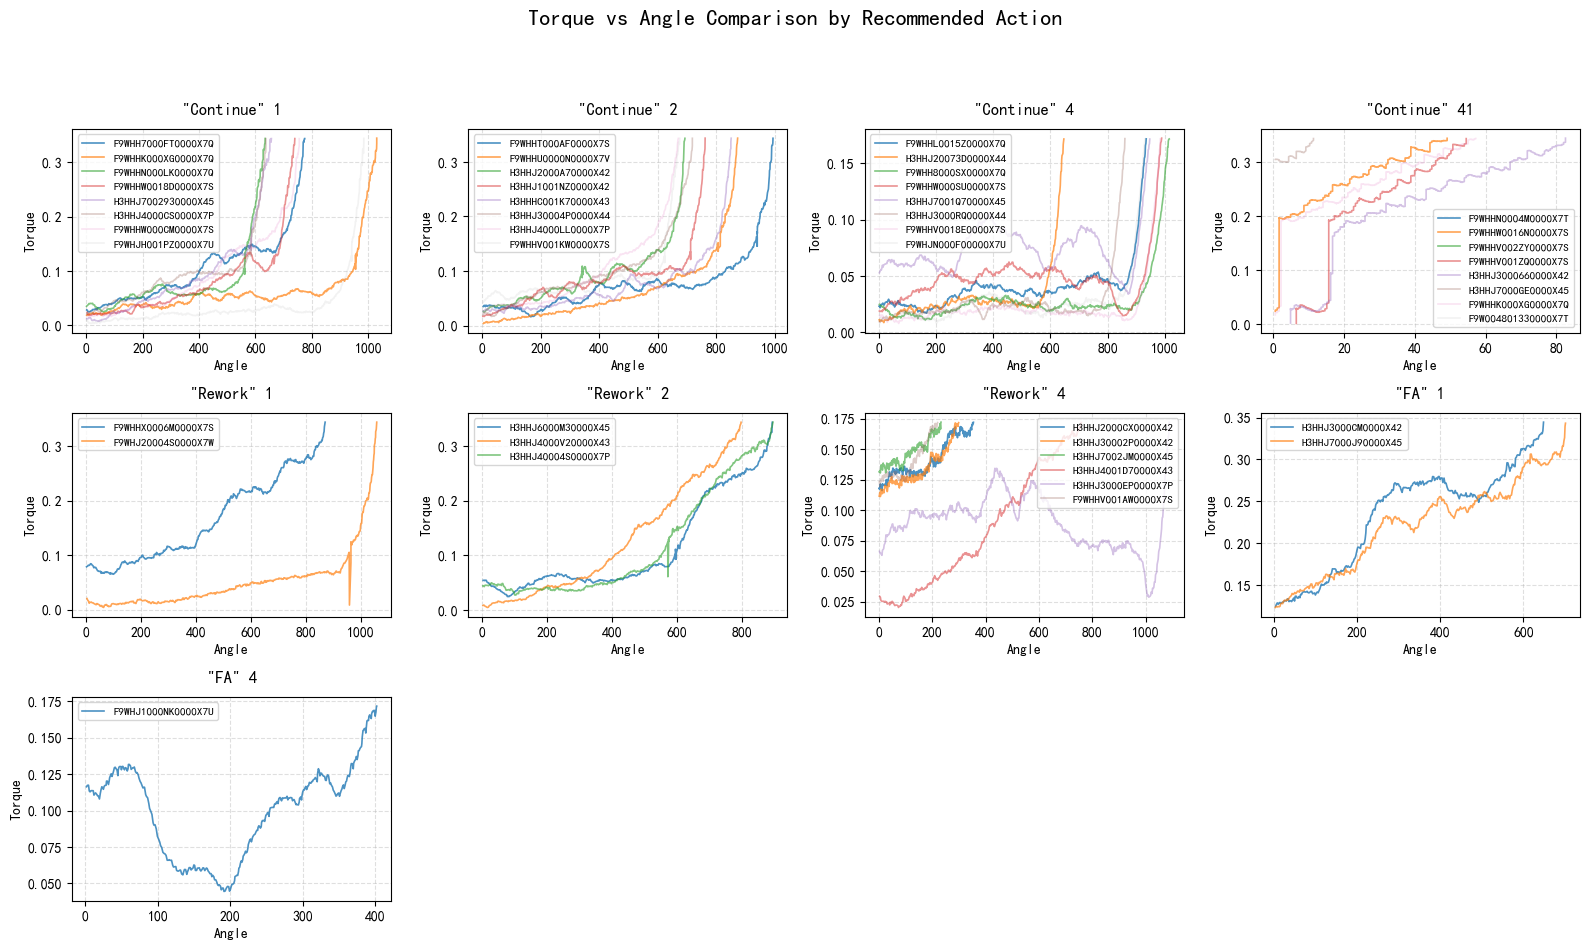

In [37]:
valid_groups, grouped = getValidGroups(df_use)
np.random.seed(1)
plot_comparison(valid_groups, grouped, screw_order, random_state=12)

In [ ]:
df_use

,hsgsn,time,screwindex,torquedata,angledata,result,filldataok,finaltorque,finalangle,maxangle,...,ErrorCode,Algorithm,setting_seat_location_thresh,setting_extrema_thresh,setting_extrema_lookback,setting_torque_thresh_start,config_file_name,rel_extrema_delta,rel_max_avg,rel_min_avg
0,F9W007140220000X7U,2025-07-16 08:04:08,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -0.54, -1.08,...",OK,True,0.17200,955.80,955.80,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc4_Half_Config_V3,0.006,0.253,0.248
1,F9W007140220000X7U,2025-07-16 08:04:08,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -0.54, -1.08,...",OK,True,0.34350,847.80,847.80,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc2_Config_V3,0.008,0.098,0.091
2,F9W007140220000X7U,2025-07-16 08:04:08,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -0.54, -1.08,...",OK,True,0.34325,1165.32,1165.32,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc1_Config_V3,0.002,0.227,0.225
3,F9W007140220000X7U,2025-07-16 08:04:08,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",OK,True,0.34325,36.18,0.00,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
4,F9W007538030000X7U,2025-07-16 08:04:09,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...",OK,True,0.17160,922.32,922.32,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc4_Half_Config_V3,0.009,0.258,0.248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7515,HVWHK0000090000XQ7,2025-07-31 19:05:04,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",OK,True,0.34350,50.22,0.00,...,NaN,Apple_TCM_Pro_v5s5.exe,0.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc41_Full_Config_V4,Not_Analyzed,Not_Analyzed,Not_Analyzed
7516,HVWHK00000F0000XQ7,2025-07-31 20:00:00,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...",OK,True,0.17160,852.66,852.66,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc4_Half_Config_V3,0.022,0.196,0.175
7517,HVWHK00000F0000XQ7,2025-07-31 20:00:00,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -0.54, -1.08,...",OK,True,0.34460,881.28,881.28,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc2_Config_V3,0.052,0.247,0.195
7518,HVWHK00000F0000XQ7,2025-07-31 20:00:00,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -1.08,...",OK,True,0.34365,683.10,683.10,...,NaN,Apple_TCM_Pro_v5s5.exe,4.0,1.0,800.0,0.01,LA6_SPK_CHG_TO_HSG_Loc1_Config_V3,0.024,0.122,0.098


## 2.2 fft

[('Continue', 1), ('Continue', 2), ('Continue', 4), ('Continue', 41), ('Rework', 1), ('Rework', 2), ('Rework', 4), ('FA', 1), ('FA', 4)]


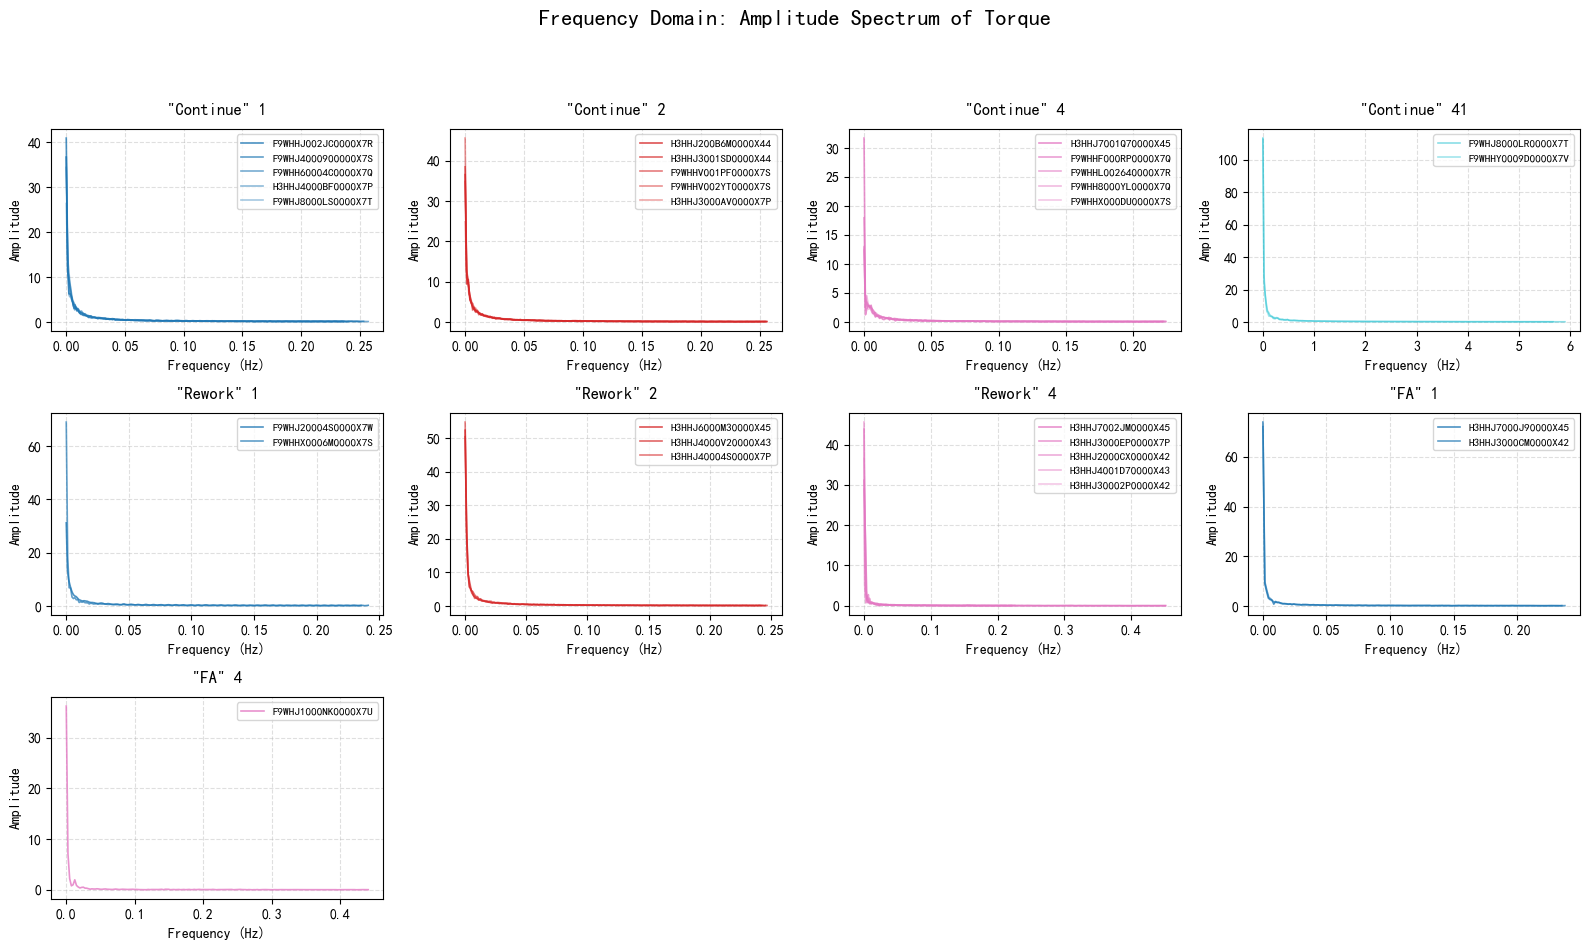

In [ ]:
from scipy.fft import fft, fftfreq

def plot_comparison_freq(valid_groups, grouped, screw_order, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # 每行最多4个，向上取整
    n_cols = min(n_groups, 4)

    # 创建画布（总尺寸根据子图数量调整）
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # 展平为一维数组方便循环
    
    screw_colors = plt.cm.get_cmap('tab10', 4)  # 使用tab10色卡（支持10种索引）
    screw_color_map = {s_idx: screw_colors(i) for i, s_idx in enumerate(screw_order)}
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # 子图标题（包含推荐动作和螺丝索引）
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Frequency (Hz)', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        
        # 获取当前组的原始数据
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(5, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        # 绘制每个采样样本的频域曲线
        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            angle_data = row['angledata']
            torque_data = row['torquedata']
            
            # 过滤掉负值（如果您有此需求）
            filtered_angle, filtered_torque = filter_negative_values(angle_data, torque_data, min_value=0)

            # 只取扭矩信号做频谱分析
            signal = filtered_torque

            # 执行FFT
            n = len(signal)
            if n == 0:
                continue  # 跳过空信号

            yf = fft(signal)
            xf = fftfreq(n, d=np.mean(np.diff(filtered_angle)))  # 假设angledata是时间或者位置的等间隔采样，用其差值作为采样间隔估计

            # 取正频率部分，并排序
            positive_freq_mask = xf >= 0
            xf_pos = xf[positive_freq_mask]
            yf_pos = np.abs(yf[positive_freq_mask])  # 取幅值（您也可以用 np.square(yf[positive_freq_mask]) 表示功率）

            # 可选：限制显示的频率范围，比如只显示前若干Hz，或对高频做截断
            max_freq_to_show = 50  # 您可以根据实际情况调整，比如 10, 50, 100 Hz
            freq_mask = xf_pos <= max_freq_to_show
            xf_display = xf_pos[freq_mask]
            yf_display = yf_pos[freq_mask]

            # 绘制频域幅值谱
            color = screw_color_map[s_idx]
            alpha = 0.8 - (sample_idx * 0.1)
            ax.plot(xf_display, yf_display, alpha=alpha, linewidth=1.2, marker='', linestyle='-', 
                    color=color, label=f"{row.get('hsgsn', f'Sample {sample_idx}')}")
        
        # 添加图例（仅显示当前子图的样本）
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.4)

    # 隐藏多余的子图
    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    
    # 添加总标题
    fig.suptitle('Frequency Domain: Amplitude Spectrum of Torque', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
valid_groups, grouped = getValidGroups()
plot_comparison_freq(valid_groups, grouped, screw_order, random_state=np.random.randint(1, 10000))

## 2.3 PSD

In [36]:
from scipy.signal import welch

def plot_comparison_psd(valid_groups, grouped, screw_order, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # 每行最多4个，向上取整
    n_cols = min(n_groups, 4)

    # 创建画布
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # 展平为一维数组方便循环
    
    screw_colors = plt.cm.get_cmap('tab10', 4)  # 使用tab10色卡
    screw_color_map = {s_idx: screw_colors(i) for i, s_idx in enumerate(screw_order)}
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # 子图标题
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Frequency (Hz)', fontsize=10)
        ax.set_ylabel('Power Spectral Density', fontsize=10)
        
        # 获取当前组数据
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(5, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            torque_signal = row['torquedata']
            angle_signal = row['angledata']

            # 过滤负值（如果您的数据需要）
            filtered_angle, filtered_torque = filter_negative_values(angle_signal, torque_signal, min_value=0)

            signal = filtered_torque  # 只分析扭矩信号

            if len(signal) < 4:
                continue  # Welch方法至少需要一定长度，太短无法分段

            # 使用 scipy.signal.welch 计算功率谱密度
            # fs: 采样频率，单位 Hz。如果您知道真实采样率，请替换！！！
            # 下面假设 angle_signal 是“位置/角度”，并且是均匀采样，用其差值估计采样间隔
            angle_diff_mean = np.mean(np.diff(filtered_angle))
            if angle_diff_mean <= 0:
                continue  # 避免除零或反向采样
            fs = 1.0 / angle_diff_mean  # 估算采样频率 = 1 / 采样间隔（单位 Hz）

            # Welch 方法参数
            f_psd, psd = welch(signal, fs=fs,
                window='hann',      # 加窗减少泄漏
                nperseg=128,        # 每段长度，可调整，如 128, 256, 512
                noverlap=None,      # 默认为 nperseg // 2
                scaling='density'   # 'density': 单位 (unit^2)/Hz；'spectrum': (unit^2)
            )

            # 只取正频率部分
            pos_freq_mask = f_psd >= 0
            f_psd_pos = f_psd[pos_freq_mask]
            psd_pos = psd[pos_freq_mask]

            # 可选：限制显示的频率范围，比如 0 ~ 50 Hz
            max_freq_to_show = 50
            freq_mask = f_psd_pos <= max_freq_to_show
            f_display = f_psd_pos[freq_mask]
            psd_display = psd_pos[freq_mask]

            # 绘制 PSD 曲线
            color = screw_color_map[s_idx]
            alpha = 0.8 - (sample_idx * 0.1)
            label_text = f"{row.get('hsgsn', f'Sample {sample_idx}')}"
            ax.plot(f_display, psd_display, alpha=alpha, linewidth=1.0, linestyle='-', label=label_text)    # , color=color

        # 图例与网格
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.4)

    # 隐藏多余的子图
    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    
    # 总标题
    fig.suptitle('Frequency Domain: Power Spectral Density of Torque Signals', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

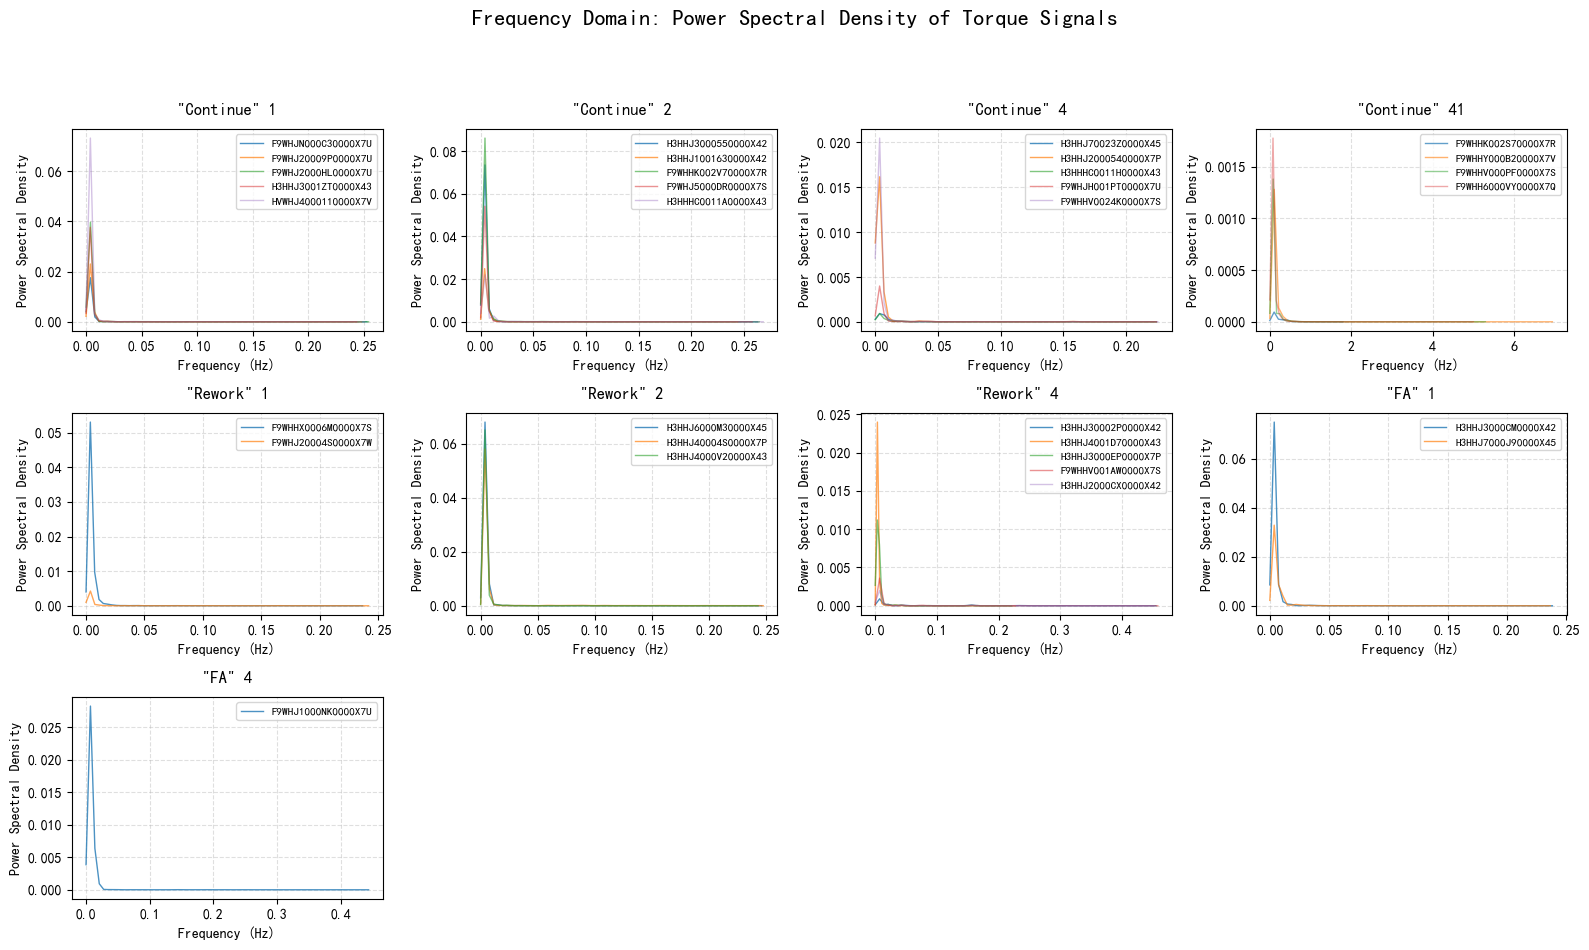

In [44]:
valid_groups, grouped = getValidGroups()
np.random.seed(1)
plot_comparison_psd(valid_groups, grouped, screw_order, random_state=11)

## 2.4 其他特征

In [68]:
from scipy import stats
from scipy.fft import fft

def extract_basic_stats(angle, torque):
    """基础统计特征：均值、方差、最大值、最小值、分位数等"""
    stats_dict = {
        'torque_mean': np.mean(torque),
        'torque_std': np.std(torque),
        'torque_max': np.max(torque),
        'torque_min': np.min(torque),
        'torque_median': np.median(torque),
        'torque_q1': np.percentile(torque, 25),
        'torque_q3': np.percentile(torque, 75),
        'angle_mean': np.mean(angle),
        'angle_max': np.max(angle),
        'angle_min': np.min(angle),
    }
    return stats_dict

def extract_trend_features(angle, torque):
    """趋势特征：线性回归斜率（整体上升/下降趋势）、多项式拟合系数等"""
    # 线性回归斜率
    x = np.array(angle).reshape(-1, 1)
    y = np.array(torque).reshape(-1, 1)
    model = stats.linregress(x.flatten(), y.flatten())
    trend_dict = {
        'torque_slope': model.slope,
        'torque_intercept': model.intercept,
        'torque_rvalue': model.rvalue,   # 相关系数
        'torque_pvalue': model.pvalue,
    }
    return trend_dict

def extract_shape_features(angle, torque):
    """曲线形状特征：波动程度、峰值/谷值数量、拐点检测等"""
    shape_dict = {}
    
    # 一阶差分（扭矩变化率）
    diff_torque = np.diff(torque)
    shape_dict['torque_diff_mean'] = np.mean(diff_torque)
    shape_dict['torque_diff_std'] = np.std(diff_torque)
    
    # 二阶差分（变化率的速率）
    diff2_torque = np.diff(diff_torque)
    shape_dict['torque_diff2_mean'] = np.mean(diff2_torque)
    shape_dict['torque_diff2_std'] = np.std(diff2_torque)
    
    # 峰值/谷值数量（简单阈值法，可根据实际调整）
    peaks = []
    valleys = []
    for i in range(1, len(torque)-1):
        if torque[i] > torque[i-1] and torque[i] > torque[i+1]:
            peaks.append(torque[i])
        elif torque[i] < torque[i-1] and torque[i] < torque[i+1]:
            valleys.append(torque[i])
    shape_dict['peak_count'] = len(peaks)
    shape_dict['valley_count'] = len(valleys)
    
    # 扭矩的最大变化幅度（从最小到最大的差值）
    shape_dict['torque_range'] = np.max(torque) - np.min(torque)
    
    return shape_dict

def extract_window_features(angle, torque, window_size=100):
    """基于窗口的局部特征：把angle切成若干窗口，在每个窗口内计算统计量"""
    window_features = {}
    n_windows = len(angle) // window_size
    if n_windows == 0:
        n_windows = 1  # 若太短，就只算一个窗口
    
    for i in range(n_windows):
        start = i * window_size
        end = (i+1) * window_size if (i+1)*window_size < len(angle) else len(angle)
        win_angle = angle[start:end]
        win_torque = torque[start:end]
        
        # 窗口内的基础统计
        win_stats = extract_basic_stats(win_angle, win_torque)
        for k, v in win_stats.items():
            window_features[f'win{i}_{k}'] = v
    
    return window_features

def extract_fft_features(angle, torque, n_components=5):
    # 如果 torque 序列太短，比如长度小于 4，那么 FFT 几乎没有意义，直接返回 nan
    if len(torque) < 4:
        return {
            'fft_energy_1': np.nan,
            'fft_energy_2': np.nan,
            'fft_energy_3': np.nan,
            'fft_energy_4': np.nan,
            'fft_energy_5': np.nan,
        }

    yf = fft(torque)
    xf = np.fft.fftfreq(len(torque), d=np.mean(np.diff(angle)))  # 频率轴

    # 只保留正频率部分：去掉直流 (idx=0) 和负频率
    # 正频率对应的索引通常是 idx > 0 且 idx < len(xf)/2
    positive_freq_mask = (xf > 0)
    xf_pos = xf[positive_freq_mask]
    yf_pos = np.abs(yf[positive_freq_mask])

    if len(xf_pos) == 0:
        # 如果没有正频率分量，也返回 nan
        return {
            'fft_energy_1': np.nan,
            'fft_energy_2': np.nan,
            'fft_energy_3': np.nan,
            'fft_energy_4': np.nan,
            'fft_energy_5': np.nan,
        }

    # 计算能量并归一化
    total_energy = np.sum(yf_pos**2)
    if total_energy == 0:
        total_energy = 1e-8
    yf_pos_norm = yf_pos / np.sqrt(total_energy)

    # 取前 n_components 个频率分量的能量
    n_take = min(n_components, len(yf_pos_norm))  # 避免越界
    fft_features = {}
    for i in range(n_take):
        fft_features[f'fft_energy_{i+1}'] = yf_pos_norm[i] ** 2

    # 如果 n_components > 实际有的分量数，剩下的键也返回 nan（可选）
    for i in range(n_take, n_components):
        fft_features[f'fft_energy_{i+1}'] = np.nan

    return fft_features

In [72]:
def extract_features(row):
    raw_angle = row['angledata']
    raw_torque = row['torquedata']
    angle, torque = filter_negative_values(raw_angle, raw_torque, min_value=0)
    if len(angle) == 0 or len(torque) == 0:
        # 如果 angle 或 torque 是空列表，则返回一个全为 np.nan 的特征字典（或填充默认值）
        # 这里我们返回一个大部分为 np.nan 的字典，后续你可以选择如何处理这些样本
        return {
            'torque_mean': np.nan,
            'torque_std': np.nan,
            'torque_max': np.nan,
            'torque_min': np.nan,
            'torque_median': np.nan,
            'torque_q1': np.nan,
            'torque_q3': np.nan,
            'angle_mean': np.nan,
            'angle_max': np.nan,
            'angle_min': np.nan,
            'torque_slope': np.nan,
            'torque_intercept': np.nan,
            'torque_rvalue': np.nan,
            'torque_pvalue': np.nan,
            'torque_diff_mean': np.nan,
            'torque_diff_std': np.nan,
            'torque_diff2_mean': np.nan,
            'torque_diff2_std': np.nan,
            'peak_count': np.nan,
            'valley_count': np.nan,
            'torque_range': np.nan,
            # 其它窗口或傅里叶特征也返回 nan
            'win0_torque_mean': np.nan,
            'fft_energy_1': np.nan,
            'fft_energy_2': np.nan,
            'fft_energy_3': np.nan,
            'fft_energy_4': np.nan,
            'fft_energy_5': np.nan,
            'loc': row['screwindex'],  # 位置还是可以保留
        }
    # 基础统计
    basic_stats = extract_basic_stats(angle, torque)
    # 趋势特征
    trend_features = extract_trend_features(angle, torque)
    # 形状特征
    shape_features = extract_shape_features(angle, torque)
    # 窗口特征（可根据数据长度调整window_size）
    # window_features = extract_window_features(angle, torque, window_size=20)
    # 傅里叶特征（可根据需要调整n_components）
    fft_features = extract_fft_features(angle, torque, n_components=5)
    # 位置特征（直接把position作为特征）
    position_feature = {'loc': row['screwindex']}
    
    # 合并所有特征
    all_features = {**basic_stats, **trend_features, **shape_features, **fft_features, **position_feature} #, **window_features
    return all_features

In [73]:
# 1. 逐行提取特征，得到字典列表
features_list = df_use.apply(extract_features, axis=1).tolist()

# 2. 转成DataFrame
features_df = pd.DataFrame(features_list)

In [76]:
# 3. 此时features_df中包含了所有的标量特征，label和position也可以join回来（如果需要）
#    下面示例：把原df_use的label和position也merge进来
final_df = pd.concat([df_use[['hsgsn', 'time', 'recommended_action']], features_df], axis=1)
final_df

,hsgsn,time,recommended_action,torque_mean,torque_std,torque_max,torque_min,torque_median,torque_q1,torque_q3,...,peak_count,valley_count,torque_range,fft_energy_1,fft_energy_2,fft_energy_3,fft_energy_4,fft_energy_5,loc,win0_torque_mean
0,F9W007140220000X7U,2025-07-16 08:04:08,Continue,0.040657,0.024250,0.17200,0.00900,0.042850,0.028750,0.045100,...,107.0,109.0,0.16300,0.130204,0.134029,0.101941,0.108233,0.089391,4,NaN
1,F9W007140220000X7U,2025-07-16 08:04:08,Continue,0.061405,0.074646,0.34350,0.00470,0.036350,0.018000,0.055900,...,97.0,100.0,0.33880,0.343274,0.223267,0.125769,0.066712,0.048196,2,NaN
2,F9W007140220000X7U,2025-07-16 08:04:08,Continue,0.067539,0.063539,0.34325,0.01630,0.047150,0.024962,0.083850,...,136.0,139.0,0.32695,0.376469,0.177685,0.096210,0.064589,0.052658,1,NaN
3,F9W007140220000X7U,2025-07-16 08:04:08,Continue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN
4,F9W007538030000X7U,2025-07-16 08:04:09,Continue,0.043297,0.020433,0.17160,0.01165,0.043250,0.034650,0.045450,...,102.0,107.0,0.15995,0.020006,0.073009,0.170126,0.117649,0.069188,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7515,HVWHK0000090000XQ7,2025-07-31 19:05:04,Continue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN
7516,HVWHK00000F0000XQ7,2025-07-31 20:00:00,Continue,0.039311,0.025902,0.17160,0.02010,0.032875,0.028488,0.038463,...,83.0,86.0,0.15150,0.100282,0.179299,0.145255,0.136428,0.107139,4,NaN
7517,HVWHK00000F0000XQ7,2025-07-31 20:00:00,Continue,0.103000,0.074479,0.34460,0.01815,0.082250,0.043100,0.144575,...,103.0,102.0,0.32645,0.506109,0.073699,0.127718,0.071059,0.041711,2,NaN
7518,HVWHK00000F0000XQ7,2025-07-31 20:00:00,Continue,0.079055,0.076663,0.34365,0.01290,0.044425,0.038288,0.074400,...,66.0,68.0,0.33075,0.433889,0.230226,0.097794,0.061480,0.025827,1,NaN


In [80]:
final_df.iloc[:, 2:].groupby(['loc', 'recommended_action']).agg(['mean', 'min'])   #, 'std'

torque_mean           torque_std           torque_max  \
                              mean       min       mean       min       mean   
loc recommended_action                                                         
1   Continue              0.086169  0.045278   0.071870  0.049290   0.343618   
    FA                    0.228135  0.222823   0.057379  0.053991   0.343875   
    Rework                0.114289  0.061079   0.071104  0.065081   0.343550   
2   Continue              0.086547  0.049940   0.072200  0.000000   0.343465   
    Rework                0.124253  0.119144   0.093630  0.085912   0.343417   
4   Continue              0.033575  0.020685   0.026164  0.003148   0.171887   
    FA                    0.101720  0.101720   0.031625  0.031625   0.171800   
    Rework                0.123284  0.084146   0.021229  0.010957   0.171842   
41  Continue              0.254055  0.093640   0.056640  0.000784   0.343595   

                                torque_min          torque_median            \
                            min       mean      min          mean       min   
loc recommended_action                                                        
1   Continue            0.34325   0.016905  0.00010      0.063621  0.021750   
    FA                  0.34325   0.124050  0.12350      0.244175  0.231300   
    Rework              0.34355   0.034775  0.00435      0.096300  0.045650   
2   Continue            0.19620   0.015709  0.00005      0.063043  0.019400   
    Rework              0.34330   0.018800  0.00465      0.082750  0.070600   
4   Continue            0.17160   0.012003  0.00070      0.027221  0.012750   
    FA                  0.17180   0.044450  0.04445      0.108925  0.108925   
    Rework              0.17165   0.087617  0.02025      0.118242  0.073600   
41  Continue            0.34325   0.134096  0.00005      0.260165  0.049600   

                        ... fft_energy_2           fft_energy_3            \
                        ...         mean       min         mean       min   
loc recommended_action  ...                                                 
1   Continue            ...     0.198546  0.019006     0.114660  0.017557   
    FA                  ...     0.220818  0.218979     0.064515  0.061666   
    Rework              ...     0.136346  0.092374     0.102771  0.088669   
2   Continue            ...     0.183681  0.021927     0.102647  0.022695   
    Rework              ...     0.129820  0.116737     0.053357  0.045392   
4   Continue            ...     0.172336  0.017058     0.140631  0.006829   
    FA                  ...     0.077091  0.077091     0.009897  0.009897   
    Rework              ...     0.110903  0.083163     0.070581  0.008116   
41  Continue            ...     0.182605  0.000225     0.087309  0.000872   

                       fft_energy_4           fft_energy_5            \
                               mean       min         mean       min   
loc recommended_action                                                 
1   Continue               0.065647  0.018309     0.042881  0.008671   
    FA                     0.043215  0.040217     0.028008  0.021457   
    Rework                 0.048109  0.022280     0.031671  0.015231   
2   Continue               0.064181  0.015561     0.042856  0.007510   
    Rework                 0.030943  0.025953     0.021719  0.015446   
4   Continue               0.113443  0.000103     0.086987  0.012369   
    FA                     0.015693  0.015693     0.061635  0.061635   
    Rework                 0.036696  0.024733     0.033020  0.000404   
41  Continue               0.044290  0.000258     0.027820  0.000282   

                       win0_torque_mean      
                                   mean min  
loc recommended_action                       
1   Continue                        NaN NaN  
    FA                              NaN NaN  
    Rework                          NaN NaN  
2   Continue                        NaN NaN  
 

## 2.5

# 3. 异常监测

## 3.1 预处理

In [39]:
# -----------------------------
# 3. 提取每个螺丝打螺丝过程的特征
# -----------------------------
def extract_features(row):
    raw_angle = row['angledata']
    raw_torque = row['torquedata']
    angle_v, torque_v = filter_negative_values(raw_angle, raw_torque, min_value=0)

    if len(angle_v) < 2:
        return pd.Series([np.nan]*12, index=['hsgsn', 'time', 'max_torque','angle_at_max','auc', 'slope_mid','slope_rise_late','total_angle', 'std_torque','row_span','valid', 'recommended_action'])

    # 1. 最大扭力 & 对应角度
    max_torque = np.max(torque_v)
    angle_at_max = angle_v[np.argmax(torque_v)]

    # 2. ✅ AUC：以 angle 为横坐标的积分 ∫ torque d(angle)
    auc = np.trapz(torque_v, angle_v)  # 单位: N·m·°

    # 斜率
    mid_angle = angle_v[len(angle_v) // 2]
    mid_torque = torque_v[len(angle_v) // 2]
    slope_mid = (max_torque - mid_torque) / (np.max(angle_v) - mid_angle + 1e-8)
    
    # 上升段斜率：前50%上升部分
    peak_idx = np.argmax(torque_v)
    mid_torque = 0.5 * max_torque
    if peak_idx < 2:
        slope_rise_late = 0.0
    else:
        # 找出后半上升段的索引
        late_rise_mask = (angle_v >= mid_torque) & (torque_v <= max_torque)
        late_rise_points = np.where(late_rise_mask)[0]

        if len(late_rise_points) >= 2:
            idx_start = late_rise_points[0]
            idx_end = late_rise_points[-1]
            delta_angle = angle_v[idx_end] - angle_v[idx_start]
            delta_torque = torque_v[idx_end] - torque_v[idx_start]
            slope_rise_late = delta_torque / (delta_angle + 1e-8)  # 防除零
        else:
            slope_rise_late = 0.0
    
    # 4. 总角度跨度（有效段）
    total_angle = angle_v[-1] - angle_v[0]
    # 5. 扭力标准差
    std_torque = np.std(torque_v)
    # 7. row_in_file 跨度
    row_span = len(angle_v)

    return pd.Series([
        row['hsgsn'], row['time'], max_torque, angle_at_max, auc, slope_mid, slope_rise_late, total_angle, std_torque, row_span, True, row['recommended_action']
    ], index=['hsgsn', 'time', 'max_torque','angle_at_max','auc', 'slope_mid','slope_rise_late','total_angle', 'std_torque','row_span','valid', 'recommended_action'])

In [40]:
def process_location_data(df_use: pd.DataFrame):
    loc_groups = df_use['screwindex'].unique()
    all_features_dfs = []

    for loc in loc_groups:
        group_df = df_use[df_use['screwindex'] == loc].copy().sort_values('time')
        print(f"\n🔧 正在处理 loc={loc}，共 {len(group_df)} 个螺丝")
        
        # 按 screw_id 分组提取特征
        features = group_df.apply(extract_features, axis=1)
        
        # 检查并处理 NaN 值
        if features.isna().any(axis=None):  # 如果存在任何 NaN 值
            features['is_abnormal'] = features.isna().any(axis=1)  # 标记包含 NaN 的行为 True
            features['abnormal_reason'] = np.where(features['is_abnormal'], '批杆问题(可能)', '')  # 假设 NaN 是由批杆问题引起的
            
            # 对于有 NaN 值的行，你可以选择填充、删除或进一步处理
            # 这里我们选择用默认值填充以便继续处理
            features.fillna({'max_torque': -1, 'angle_at_max': -1, 'auc': -1,
                             'slope_rise_late': -1, 'total_angle': -1,
                             'std_torque': -1, 'duration_sec': -1, 'row_span': -1}, inplace=True)
        else:
            features['is_abnormal'] = False
            features['abnormal_reason'] = ''
        
        features = features[features['valid'].fillna(False)].reset_index(drop=True)
        # 添加 loc 标签
        features['loc'] = loc
        
        all_features_dfs.append(features)

    # 合并所有 loc 的特征
    final_features = pd.concat(all_features_dfs, ignore_index=True)
    final_features = final_features.reset_index(drop=True)
    
    return final_features

final_features = process_location_data(df_use)


🔧 正在处理 loc=4，共 1942 个螺丝

🔧 正在处理 loc=2，共 1927 个螺丝

🔧 正在处理 loc=1，共 1935 个螺丝

🔧 正在处理 loc=41，共 1716 个螺丝


## 3.2 趋势分析与预警

In [41]:
final_features[final_features['recommended_action'] == 'Continue'][['hsgsn', 'time', 'max_torque','angle_at_max','auc', 'slope_mid','slope_rise_late','total_angle', 'std_torque','row_span']].describe()

,time,max_torque,angle_at_max,auc,slope_mid,slope_rise_late,total_angle,std_torque,row_span
count,6852,6852.000000,6852.000000,6852.000000,6.852000e+03,6852.000000,6852.00000,6852.000000,6852.000000
mean,2025-07-26 09:54:04.299766528,0.295222,734.270911,42.683652,5.757455e+02,0.001091,732.14535,0.056703,410.019848
min,2025-07-16 08:04:08,0.171600,1.080000,0.176540,1.730170e-04,0.000017,0.54000,0.000784,3.000000
25%,2025-07-24 09:01:00,0.172150,676.620000,25.185303,3.906710e-04,0.000209,674.86500,0.027290,364.000000
50%,2025-07-25 16:02:03.500000,0.343400,827.280000,43.489696,7.269470e-04,0.000377,825.12000,0.068424,417.000000
75%,2025-07-28 19:01:01,0.343700,944.460000,58.718780,9.237720e-04,0.000472,942.30000,0.074763,469.000000
max,2025-07-31 20:00:00,0.344900,1292.220000,156.862643,2.150000e+06,0.038519,1290.60000,0.109258,775.000000
std,NaN,0.077258,327.708642,22.750805,2.981002e+04,0.002037,327.48399,0.025064,111.733379


In [70]:
# ======================
# 1. 选择关注的列
# ======================
window_size = 10
feature_cols = ['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']
features_datas = final_features[['loc', 'recommended_action', *feature_cols]].copy()
for col in feature_cols:
    features_datas[f'{col}_z'] = (features_datas[col] - features_datas[col].rolling(window=window_size, min_periods=1).mean()).abs() / (features_datas[col].rolling(window=window_size, min_periods=1).std())

feature_cols = [f'{f}_z' for f in feature_cols]
# ======================
# 2. 按 loc 和 recommended_action 分组，统计特征列的统计量
# ======================
# 选择你想要的统计函数，比如：均值、标准差、最小值、最大值、中位数等
stats_functions = ['mean', 'std', 'min', 'max', 'median']
# 分组：先按 loc，再按 recommended_action，然后对每个特征列计算统计量
grouped = features_datas.groupby(['loc', 'recommended_action'])[feature_cols].agg(stats_functions)

# ======================
# 3. 只提取 recommended_action 为 'Continue' 和 非 'Continue' 的情况
# ======================
# 获取所有唯一的 recommended_action 值
all_actions = features_datas['recommended_action'].unique()

# 筛选感兴趣的两类：
# - action_continue: recommended_action == 'Continue'
# - action_others: recommended_action != 'Continue'
action_continue = 'Continue'
action_others_mask = features_datas['recommended_action'] != action_continue

# 方式一：如果你想分别查看 'Continue' 和 其它 情况的统计，可以分别提取
grouped_continue = grouped.xs(action_continue, level='recommended_action', drop_level=False)
grouped_others = grouped.drop(index=grouped_continue.index)  # 或者用 mask 筛选

# 方式二（更灵活）：直接在后续处理中区分 'Continue' 和 非 'Continue'
# 我们推荐接下来统一处理，把所有 loc + action 的组合都展示，并人工对比 Continue vs 其它

# ======================
# 4. 扁平化多级列名（便于查看和导出）
# ======================
# grouped 的列是多级索引：(feature, stat_func)，比如 ('hsgsn', 'mean')
# 如果希望列名更易读，可以扁平化，例如：'hsgsn_mean', 'hsgsn_std', ...
grouped_flat = grouped.reset_index()  # 把 loc 和 recommended_action 从索引恢复为列
grouped_flat.columns = ['loc', 'recommended_action'] + [f"{col}_{stat}" for col, stat in grouped_flat.columns[2:]]

# ======================
# 5. 筛选只展示 'Continue' 和 非 'Continue' 的行
# ======================
grouped_final = grouped_flat[grouped_flat['recommended_action'].isin([action_continue] + [a for a in all_actions if a != action_continue])]

# 如果你只想对比 'Continue' vs 其它（不关心具体是哪种非 Continue），可以进一步分组
# 例如，把所有非 Continue 合并为一组（可选，下面提供示例）

# ======================
# 6. （可选）将非 Continue 的所有情况合并为 "Not_Continue" 一组，便于对比
# ======================
# 方法：新建一列，将 recommended_action 映射为 'Continue' 或 'Not_Continue'
features_datas['action_group'] = features_datas['recommended_action'].apply(lambda x: 'Continue' if x == action_continue else 'Not_Continue')

# 然后按 loc 和 action_group 分组统计
grouped_combined = features_datas.groupby(['loc', 'action_group'])[feature_cols].agg(stats_functions).reset_index()
grouped_combined_flat = grouped_combined.copy()
grouped_combined_flat.columns = ['loc', 'action_group'] + [f"{col}_{stat}" for col, stat in grouped_combined_flat.columns[2:]]
grouped_combined_flat

,loc,action_group,max_torque_z_mean,max_torque_z_std,max_torque_z_min,max_torque_z_max,max_torque_z_median,angle_at_max_z_mean,angle_at_max_z_std,angle_at_max_z_min,...,std_torque_z_mean,std_torque_z_std,std_torque_z_min,std_torque_z_max,std_torque_z_median,row_span_z_mean,row_span_z_std,row_span_z_min,row_span_z_max,row_span_z_median
0,1,Continue,0.785628,0.530786,0.000000,2.718256,0.718936,0.806693,0.513375,0.001241,...,0.773260,0.551268,0.000291,2.661689,0.674434,0.807835,0.513595,0.000000,2.369341,0.750343
1,1,Not_Continue,0.854432,0.986067,0.017529,2.127049,0.636574,0.606211,0.427771,0.048498,...,1.320651,0.639078,0.789642,2.209514,1.141723,0.747492,0.348974,0.381045,1.131372,0.738776
2,2,Continue,0.787947,0.542660,0.000000,2.846030,0.708444,0.799646,0.517472,0.000758,...,0.774061,0.558398,0.000252,2.824098,0.662699,0.794527,0.526690,0.001435,2.667847,0.744420
3,2,Not_Continue,0.580095,0.477105,0.300598,1.130988,0.308697,0.746006,0.207870,0.537392,...,1.759629,0.593049,1.120959,2.292932,1.864995,0.722299,0.325680,0.368660,1.009896,0.788342
4,4,Continue,0.794197,0.523590,0.000000,2.735364,0.738198,0.786175,0.516982,0.001987,...,0.775788,0.543728,0.000133,2.809793,0.682091,0.791133,0.516618,0.000000,2.690636,0.740526
5,4,Not_Continue,0.572198,0.220321,0.201637,0.756787,0.656781,2.203290,0.648380,0.943941,...,2.268387,0.450571,1.351661,2.640835,2.349248,1.808462,0.508953,0.941652,2.382568,1.806133
6,41,Continue,0.802893,0.531165,0.000000,2.714105,0.744595,0.804892,0.510785,0.001327,...,0.872433,0.376843,0.002928,2.803826,0.866283,0.865837,0.391504,0.003768,2.753203,0.854501


- 1
    - max_torque_z_std, auc_z_mean, auc_z_std, slope_rise_late_z_mean, std_torque_z_mean, std_torque_z
- 2
    - auc_z_mean
- 4
    - max_torque_z, auc_z, 

In [20]:
final_features

,hsgsn,time,max_torque,angle_at_max,auc,slope_rise_late,total_angle,std_torque,row_span,valid,recommended_action,is_abnormal,abnormal_reason,loc
0,F9W007140220000X7U,2025-07-16 08:04:08,0.17200,955.80,39.168968,0.000168,1220.94,0.025329,547,True,Continue,False,,4
1,F9W007538030000X7U,2025-07-16 08:04:09,0.17160,922.32,40.454167,0.000171,1186.92,0.023311,531,True,Continue,False,,4
2,F9W007499960000X7U,2025-07-16 08:05:00,0.17215,1114.02,46.304379,0.000135,1378.62,0.022874,616,True,Continue,False,,4
3,F9W007280610000X7U,2025-07-17 08:05:02,0.17210,1174.50,58.489695,0.000140,1439.10,0.026472,642,True,Continue,False,,4
4,F9W007291290000X7U,2025-07-17 08:05:03,0.17165,1130.22,51.339136,0.000127,1395.36,0.021980,623,True,Continue,False,,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7515,HVWHK00000C0000XQ7,2025-07-31 19:04:04,0.34340,-10.26,16.655423,0.000000,75.60,0.099307,355,True,Continue,False,,41
7516,HVWHK0000080000XQ7,2025-07-31 19:04:06,0.34325,-46.44,10.813824,0.000000,54.00,0.100332,306,True,Continue,False,,41
7517,HVWHK00000E0000XQ7,2025-07-31 19:04:08,0.34330,70.20,14.261967,0.005271,64.80,0.094721,653,True,Continue,False,,41
7518,HVWHK0000090000XQ7,2025-07-31 19:05:04,0.34350,-10.26,12.671532,0.000000,61.02,0.095687,319,True,Continue,False,,41


### 3.2.1 方案一

1. 未归一化

In [75]:
# -----------------------------
# 4. 趋势分析与预警（基于滑动窗口统计）
# -----------------------------
loc_results = {}
window_size = 10
# 特征权重（工程经验：AUC 和 slope 更敏感）
weights = {
    1: {
        'slope_mid': 5,
        'slope_rise_late': 5,
        'std_torque': 1,
    },
    2: {
        'slope_mid': 5,
        'slope_rise_late': 5,
        'std_torque': 1,
    },
    4: {
        'slope_mid': 2,
        'auc': 4,
        'slope_rise_late': 5,
        'max_torque': 8,
        'angle_at_max': 6,
        'std_torque': 4,
    },
    41: {
        'max_torque': 8,
        'slope_rise_late': 8,
        'angle_at_max': 6,
        'auc': 3,
    }
}
threshold = 2.2

for loc in final_features['loc'].unique():
    data_loc = final_features[final_features['loc'] == loc].copy()
    feature_cols = list(weights.get(loc, None).keys())

    # 滑动窗口标准化
    for col in feature_cols:
        data_loc[f'{col}_z'] = (
            data_loc[col] - data_loc[col].rolling(window=window_size, min_periods=1).mean()
        ) / (data_loc[col].rolling(window=window_size, min_periods=1).std())

    # 加权异常得分
    data_loc['weighted_zsum'] = sum(data_loc[f'{col}_z'].abs() * weight for col, weight in weights.get(loc, None).items())
    data_loc['anomaly_score'] = data_loc['weighted_zsum'] / sum(weights.get(loc, None).values())
    # 预警阈值
    data_loc['suggest_replace'] = data_loc['anomaly_score'] > threshold
    loc_results[loc] = data_loc
    # print(f"\n📈 loc={loc} 特征趋势与预警结果：")
    # print(data_loc[['anomaly_score', 'suggest_replace'] + feature_cols].tail(3))

2. 归一化

In [151]:
from sklearn.ensemble import IsolationForest

loc_groups = final_features['loc'].unique()
feature_cols = ['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']
bad_results = []

for loc in loc_groups:
    data = final_features[final_features['loc'] == loc].copy()
    # 滑动窗口标准化
    for col in feature_cols:
        data[f'{col}_z'] = (data[col] - data[col].rolling(window=window_size, min_periods=1).mean()).abs() / (data_loc[col].rolling(window=window_size, min_periods=1).std() + 1e-6)

    clf = IsolationForest(n_estimators=100, contamination=0.002, random_state=1)
    X = data[[f'{f}_z' for f in feature_cols]].fillna(0)
    # X = data[['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']].fillna(0)
    # 计算加权异常分数
    y_pred = clf.fit_predict(X)
    anomaly_scores = -clf.score_samples(X)  # 转换为"越异常分数越高"
    data['anomaly_score'] = anomaly_scores
    data['is_anomaly'] = (y_pred == -1).astype(int)
    bad_results.append(data[(data['recommended_action'] != 'Continue') | (data['is_anomaly'] == 1)])

bad_results = pd.concat(bad_results, ignore_index=True)
bad_results[['hsgsn', 'time', 'recommended_action', 'is_anomaly', 'loc', 'anomaly_score']]

,hsgsn,time,recommended_action,is_anomaly,loc,anomaly_score
0,H3HHJ2000CX0000X42,2025-07-22 12:04:01,Rework,0,4,0.500000
1,H3HHJ7002JM0000X45,2025-07-23 10:04:09,Rework,0,4,0.500000
2,H3HHJ4001D70000X43,2025-07-24 13:05:08,Rework,0,4,0.500000
3,F9WHHV001AW0000X7S,2025-07-24 15:04:05,Rework,0,4,0.500000
4,F9WHJ1000NK0000X7U,2025-07-26 09:01:00,FA,0,4,0.500000
5,H3HHJ30002P0000X42,2025-07-26 13:02:03,Rework,0,4,0.500000
6,H3HHJ3000EP0000X7P,2025-07-30 13:04:03,Rework,0,4,0.500000
7,H3HHJ6000M30000X45,2025-07-23 19:02:09,Rework,0,2,0.500000
8,H3HHJ4000V20000X43,2025-07-24 14:01:07,Rework,0,2,0.500000
9,H3HHJ40004S0000X7P,2025-07-30 14:03:07,Rework,0,2,0.500000


In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

weights = {
    1: {
        'slope_mid': 5,
        'slope_rise_late': 5,
        'std_torque': 1,
    },
    2: {
        'slope_mid': 5,
        'slope_rise_late': 5,
        'std_torque': 1,
    },
    4: {
        'slope_mid': 2,
        'auc': 4,
        'slope_rise_late': 5,
        'max_torque': 8,
        'angle_at_max': 6,
        'std_torque': 4,
    },
    41: {
        'max_torque': 8,
        'slope_rise_late': 8,
        'angle_at_max': 6,
        'auc': 3,
    }
}
threshold = 2.2

def process_locations(final_features, weights, threshold=2.2):
    loc_results = {}
    
    # 为所有特征创建全局归一化器
    all_features = []
    for loc in final_features['loc'].unique():
        if weights.get(loc):
            all_features.extend(weights[loc].keys())
    all_features = list(set(all_features))
    
    # 创建特征归一化器
    feature_scalers = {feature: StandardScaler() for feature in all_features}
    
    for loc in final_features['loc'].unique():
        data_loc = final_features[final_features['loc'] == loc].copy()
        
        # 应用全局特征归一化
        for feature in all_features:
            if feature in data_loc.columns:
                data_loc[feature] = feature_scalers[feature].fit_transform(data_loc[[feature]].apply(abs))
        
        feature_cols = list(weights.get(loc, {}).keys())
        
        # 滑动窗口标准化（保留，作为第二层标准化）
        for col in feature_cols:
            data_loc[f'{col}_z'] = (
                data_loc[col] - data_loc[col].rolling(window=window_size, min_periods=1).mean()
            ) / (data_loc[col].rolling(window=window_size, min_periods=1).std())
        
        clf = IsolationForest(n_estimators=50, contamination=0.003, random_state=1)
        X = data_loc[feature_cols].fillna(0)    # [f'{col}_z' for col in feature_cols]
        # 计算加权异常分数
        y_pred = clf.fit_predict(X)
        anomaly_scores = -clf.score_samples(X)  # 转换为"越异常分数越高"
        data_loc['anomaly_score'] = anomaly_scores
        data_loc['is_anomaly'] = (y_pred == -1).astype(int)
        
        # 计算权重总和，用于归一化
        # weight_sum = sum(weights.get(loc, {}).values())
        # if weight_sum == 0:
        #     weight_sum = 1  # 防止除以零
        
        # 加权异常得分（调整权重范围，使不同loc的权重更具可比性）
        # weighted_scores = []
        # for col, weight in weights.get(loc, {}).items():
        #     # 使用标准化后的特征值而非原始值
        #     weighted_scores.append((data_loc[f'{col}_z'].abs() * weight).values)
        
        # if weighted_scores:
        #     data_loc['weighted_zsum'] = np.sum(np.vstack(weighted_scores), axis=0) / weight_sum
        #     data_loc['anomaly_score'] = data_loc['weighted_zsum']
            
        #     # 动态调整阈值（基于当前数据的百分位数）
        #     data_loc['suggest_replace'] = data_loc['anomaly_score'] > threshold
        
        loc_results[loc] = data_loc
    
    return loc_results

In [159]:
loc_results = process_locations(final_features, weights, threshold=2.2)

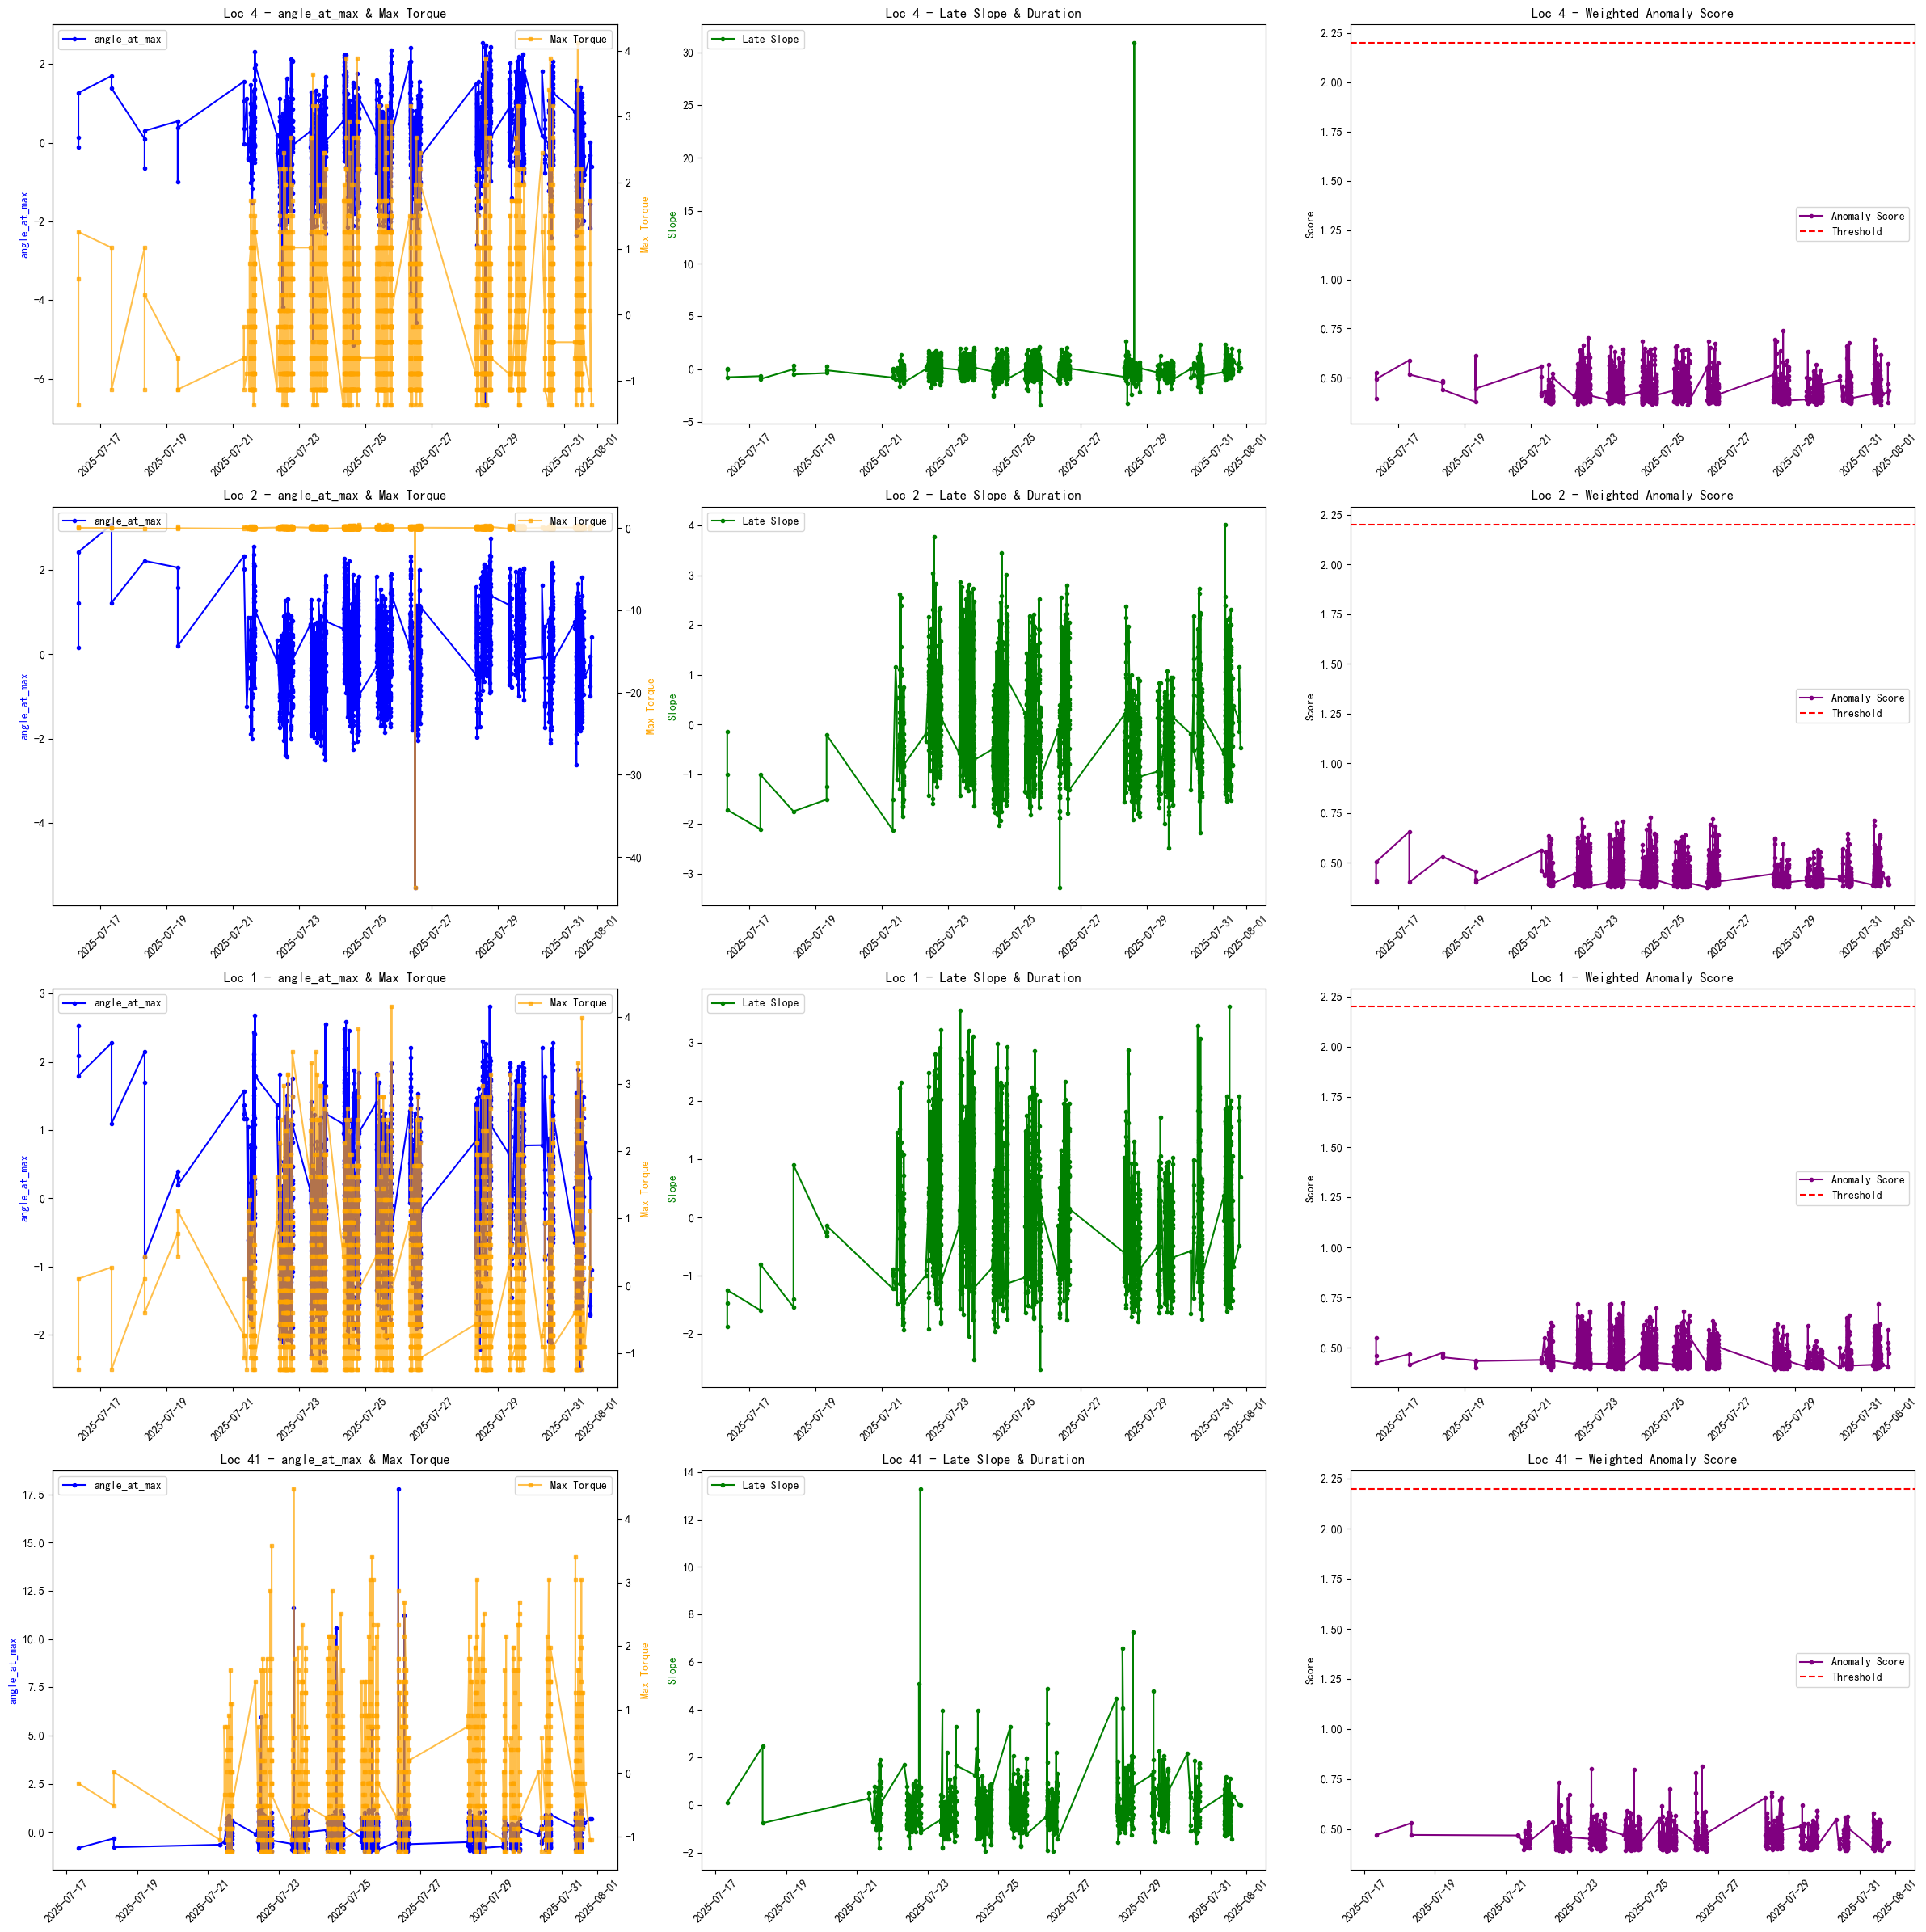

In [147]:
def plotresults(threshold):
    fig, axes = plt.subplots(len(loc_results), 3, figsize=(24, 6 * len(loc_results)), squeeze=False)

    for i, (loc, data) in enumerate(loc_results.items()):
        ax1, ax2, ax3 = axes[i]

        # 图1：AUC + Max Torque
        ax1.plot(data['time'], data['angle_at_max'], 'o-', label='angle_at_max', color='blue', markersize=3)
        ax1_twin = ax1.twinx()
        ax1_twin.plot(data['time'], data['max_torque'], 's-', label='Max Torque', color='orange', alpha=0.7, markersize=3)
        ax1.set_title(f'Loc {loc} - angle_at_max & Max Torque')
        ax1.set_ylabel('angle_at_max', color='blue')
        ax1_twin.set_ylabel('Max Torque', color='orange')
        ax1.legend(loc='upper left')
        ax1_twin.legend(loc='upper right')

        # 图2：上升后半斜率 + 时间跨度
        ax2.plot(data['time'], data['slope_rise_late'], 'o-', label='Late Slope', color='green', markersize=3)
        ax2.set_title(f'Loc {loc} - Late Slope & Duration')
        ax2.set_ylabel('Slope', color='green')
        ax2.legend(loc='upper left')

        # 图3：综合异常得分
        ax3.plot(data['time'], data['anomaly_score'], 'o-', label='Anomaly Score', color='purple', markersize=3)
        ax3.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        ax3.set_title(f'Loc {loc} - Weighted Anomaly Score')
        ax3.set_ylabel('Score')
        ax3.legend()

    # 调整子图之间的间距
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    # 旋转横坐标标签
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plotresults(2.2)

In [160]:
bad_results = []

for i, (loc, data) in enumerate(loc_results.items()):
    #  | (data['suggest_replace'] == True)
    bad_results.append(data[(data['recommended_action'] != 'Continue') | (data['is_anomaly'] == 1)])

bad_results = pd.concat(bad_results, ignore_index=True)
# [bad_results['weighted_zsum'] != float('inf')], 'row_span_z', 'suggest_replace', 'weighted_zsum'
bad_results[['hsgsn', 'time', 'loc', 'recommended_action', 'is_anomaly', 'anomaly_score', 'max_torque_z',
       'auc_z', 'angle_at_max_z', 'slope_rise_late_z', 'std_torque_z']].sort_values(['recommended_action'], ascending=False)


,hsgsn,time,loc,recommended_action,is_anomaly,anomaly_score,max_torque_z,auc_z,angle_at_max_z,slope_rise_late_z,std_torque_z
0,H3HHJ2000CX0000X42,2025-07-22 12:04:01,4,Rework,0,0.632705,0.606092,1.962094,-2.629349,-0.663622,-2.526757
6,H3HHJ30002P0000X42,2025-07-26 13:02:03,4,Rework,0,0.647147,-0.656781,2.425853,-2.589510,0.822389,-2.640835
19,H3HHJ40004S0000X7P,2025-07-30 14:03:07,2,Rework,0,0.648070,NaN,NaN,NaN,-0.895279,2.292932
16,H3HHJ4000V20000X43,2025-07-24 14:01:07,2,Rework,0,0.657035,NaN,NaN,NaN,0.100812,1.864995
15,H3HHJ6000M30000X45,2025-07-23 19:02:09,2,Rework,0,0.557459,NaN,NaN,NaN,-1.041883,1.120959
28,F9WHJ20004S0000X7W,2025-07-29 18:00:08,1,Rework,0,0.449397,NaN,NaN,NaN,-1.087298,-0.930557
10,H3HHJ3000EP0000X7P,2025-07-30 13:04:03,4,Rework,0,0.660176,0.201637,2.744390,1.673501,-2.193092,-1.351661
4,F9WHHV001AW0000X7S,2025-07-24 15:04:05,4,Rework,0,0.646047,-0.743614,0.201424,-2.573981,1.559613,-2.322822
3,H3HHJ4001D70000X43,2025-07-24 13:05:08,4,Rework,0,0.632508,-0.756787,2.084183,-0.943941,0.282158,2.618812
2,H3HHJ7002JM0000X45,2025-07-23 10:04:09,4,Rework,0,0.656546,0.716162,0.039592,-2.550659,0.184246,-2.349248


In [82]:
bad_results[bad_results['weighted_zsum'] != float('inf')][[
    'loc', 'recommended_action', 'anomaly_score', 'max_torque_z', 'auc_z', 'angle_at_max_z', 'slope_rise_late_z', 'std_torque_z', 'weighted_zsum'
]].groupby(['loc', 'recommended_action']).agg(['mean'])

anomaly_score max_torque_z     auc_z angle_at_max_z  \
                                mean         mean      mean           mean   
loc recommended_action                                                       
1   Continue                2.289366          NaN       NaN            NaN   
    FA                      1.755656          NaN       NaN            NaN   
    Rework                  1.201838          NaN       NaN            NaN   
2   Continue                2.346237          NaN       NaN            NaN   
    Rework                  0.853547          NaN       NaN            NaN   
4   Continue                2.246256     1.448079 -2.455301      -2.472019   
    FA                      1.563432    -0.324314  2.512375      -2.462089   
    Rework                  1.422257    -0.105548  1.576256      -1.602323   
41  Continue                2.362269     2.121031  2.829038       2.835035   

                       slope_rise_late_z std_torque_z weighted_zsum  
                                    mean         mean          mean  
loc recommended_action                                               
1   Continue                    2.344791     1.273209     25.183021  
    FA                         -1.475658    -1.781202     19.312220  
    Rework                     -1.109861    -0.070457     13.220219  
2   Continue                    2.386351     1.856475     25.808602  
    Rework                     -0.612117     1.759629      9.389020  
4   Continue                    2.647791    -0.230560     65.141412  
    FA                         -0.870281     2.068577     45.339539  
    Rework                     -0.001385    -1.428752     41.245457  
41  Continue                   -2.073893          NaN     59.056718

In [144]:
# ==================== 绘图函数 ====================
def plot_comparison_test(valid_groups, grouped, random_state=2):
    n_groups = len(valid_groups)
    n_rows = (n_groups + 3) // 4  # 每行最多4个，向上取整
    n_cols = min(n_groups, 4)

    # 创建画布（总尺寸根据子图数量调整）
    total_fig_size = (n_cols * 4, n_rows * 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=total_fig_size, constrained_layout=True)
    axes = axes.ravel()  # 展平为一维数组方便循环
    
    for plot_idx, (action, s_idx) in enumerate(valid_groups):
        ax = axes[plot_idx]
        
        # 子图标题（包含推荐动作和螺丝索引）
        ax.set_title(f'"{action}" {s_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Angle', fontsize=10)
        ax.set_ylabel('Torque', fontsize=10)
        
        # 获取当前组的原始数据
        group = grouped.get_group((action, s_idx))
        sampled_group = group.sample(n=min(20, len(group)), random_state=random_state) if len(group) > 0 else pd.DataFrame()

        # 绘制每个采样样本的曲线
        for sample_idx, (row_idx, row) in enumerate(sampled_group.iterrows()):
            # 原始数据
            raw_angle = row['angledata']
            raw_torque = row['torquedata']
            filtered_angle, filtered_torque = filter_negative_values(raw_angle, raw_torque, min_value=0)

            # 绘制曲线（使用固定颜色区分螺丝索引，透明度区分样本）, color=screw_color_map[s_idx]
            ax.plot(filtered_angle, filtered_torque, alpha=1 - (sample_idx * 0.02), linewidth=1.2, marker='', linestyle='-', label=row['hsgsn'])
        # 添加图例（仅显示当前子图的样本）
        if len(sampled_group) < 5:
            ax.legend(loc='best', fontsize=8)    # frameon=True, 
        ax.grid(True, linestyle='--', alpha=0.4)

    for idx in range(len(valid_groups), len(axes)):
        axes[idx].axis('off')
    # 添加总标题
    fig.suptitle('Torque vs Angle Comparison by Recommended Action', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

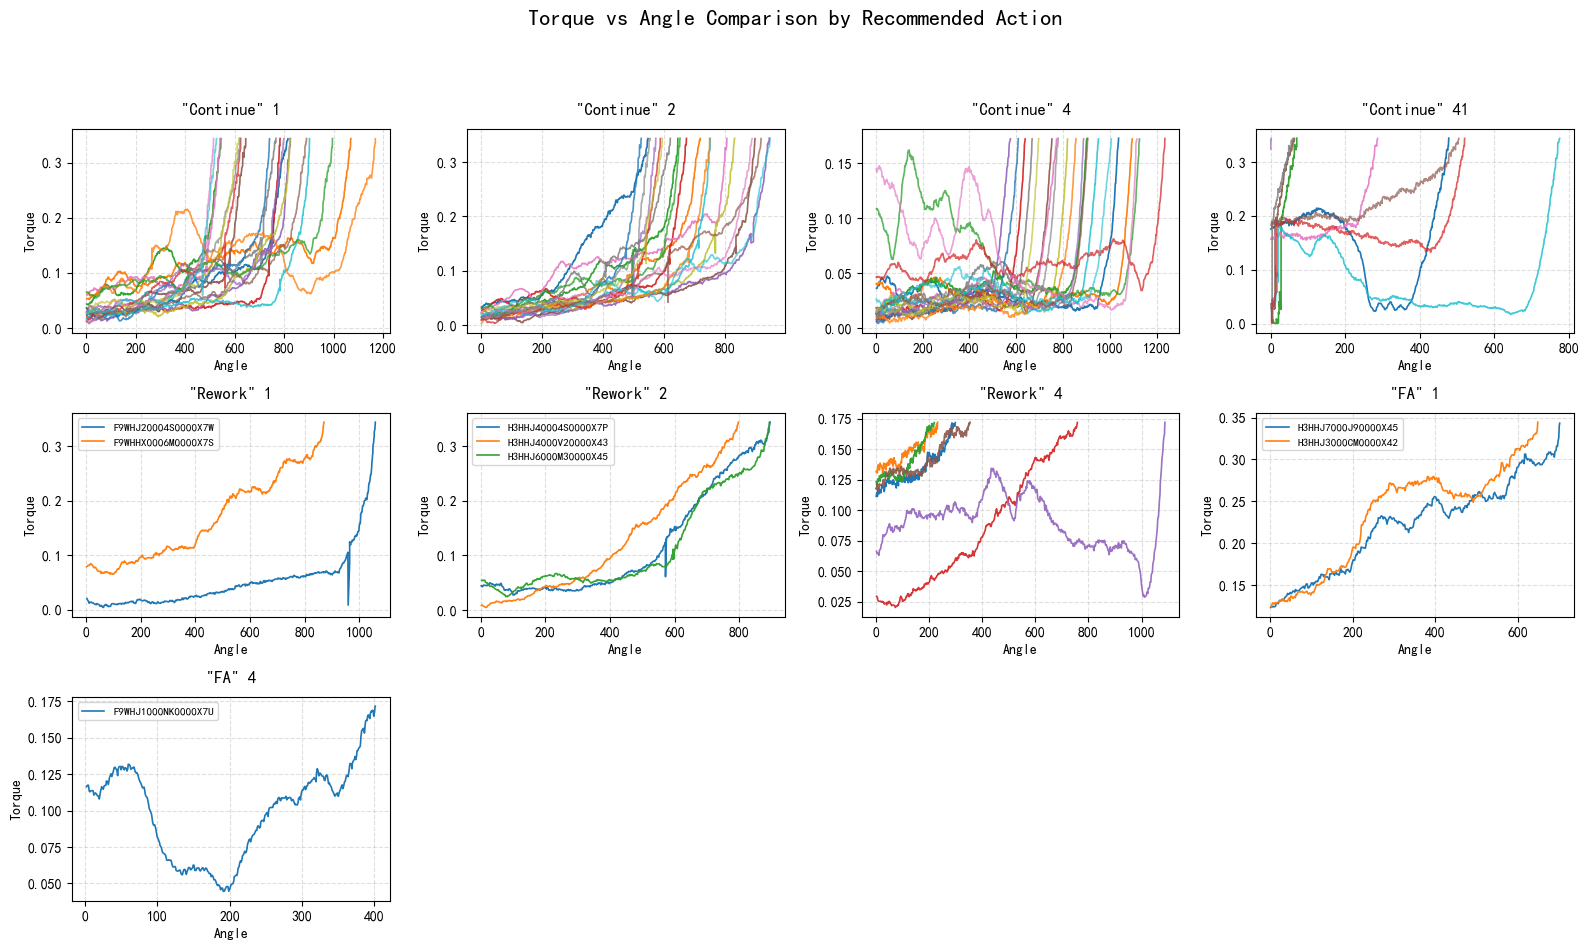

In [145]:
test_groups, group_test = getValidGroups(df_use[df_use['hsgsn'].isin(bad_results['hsgsn'].values)])
# np.random.seed(1)
plot_comparison_test(test_groups, group_test, random_state=2)

### 3.2.2 方案二

更不靠谱，应该是特征不够准确

In [ ]:
from sklearn.ensemble import IsolationForest

loc_groups = final_features['loc'].unique()
feature_cols = ['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']
bad_results = []

for loc in loc_groups:
    data = final_features[final_features['loc'] == loc].copy()
    # 滑动窗口标准化
    for col in feature_cols:
        data[f'{col}_z'] = (data[col] - data[col].rolling(window=window_size, min_periods=1).mean()).abs() / (data_loc[col].rolling(window=window_size, min_periods=1).std() + 1e-6)

    clf = IsolationForest(n_estimators=100, contamination=0.005, random_state=1)
    X = data[[f'{f}_z' for f in feature_cols]].fillna(0)
    # X = data[['max_torque', 'angle_at_max', 'auc', 'slope_rise_late', 'total_angle', 'std_torque', 'row_span']].fillna(0)
    # 计算加权异常分数
    y_pred = clf.fit_predict(X)
    anomaly_scores = -clf.score_samples(X)  # 转换为"越异常分数越高"
    data['anomaly_score'] = anomaly_scores
    data['is_anomaly'] = (y_pred == -1).astype(int)
    bad_results.append(data[(data['recommended_action'] != 'Continue') | (data['is_anomaly'] == 1)])

bad_results = pd.concat(bad_results, ignore_index=True)
bad_results[['hsgsn', 'time', 'recommended_action', 'is_anomaly', 'loc', 'anomaly_score']]

,hsgsn,time,recommended_action,is_anomaly,loc,anomaly_score
0,H3HHJ2000CX0000X42,2025-07-22 12:04:01,Rework,1,4,0.684597
1,F9WHHY000190000X7S,2025-07-22 18:02:06,Continue,1,4,0.684714
2,H3HHJ7002JM0000X45,2025-07-23 10:04:09,Rework,1,4,0.736463
3,F9WHHN0005H0000X7T,2025-07-24 09:05:09,Continue,1,4,0.686334
4,H3HHJ4001D70000X43,2025-07-24 13:05:08,Rework,0,4,0.597774
5,F9WHHV001AW0000X7S,2025-07-24 15:04:05,Rework,1,4,0.729613
6,F9WHHV002650000X7S,2025-07-24 15:05:04,Continue,1,4,0.668648
7,F9WHJ1000NK0000X7U,2025-07-26 09:01:00,FA,0,4,0.632158
8,H3HHJ30002P0000X42,2025-07-26 13:02:03,Rework,1,4,0.733975
9,F9WHJ3000KV0000X7T,2025-07-28 10:05:06,Continue,1,4,0.720446
